In [2]:
!pip install qiskit qiskit-aer qiskit[visualization] --quiet


  DEPRECATION: Building 'pylatexenc' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pylatexenc'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
import random

#Step 1 - Intialising Registers
data = QuantumRegister(3,'data')
ancilla = QuantumRegister(2,'ancilla')
syndrome = ClassicalRegister(2,'syndrome')
output = ClassicalRegister(1,'Output')
qc = QuantumCircuit(data,ancilla,syndrome,output)

#Step 2 - Encoding
alpha, beta = np.sqrt(0.7), np.sqrt(0.3)
qc.initialize([alpha,beta],data[0])
qc.cx(data[0],data[1])
qc.cx(data[0],data[2])



#Step 3 - Error inducing
error_qubit = random.randint(0,3)
if error_qubit < 3:
    qc.x(data[error_qubit])
    print(f"Error injected in qubit data[{error_qubit}]")

else:
    print("No error injected")


#Step 4 - Reciever - Detecting and C
qc.cx(data[0],ancilla[0])
qc.cx(data[2],ancilla[0])
qc.cx(data[1], ancilla[1])
qc.cx(data[2], ancilla[1])
qc.barrier()
qc.measure(ancilla[0], syndrome[0]) # syndrome[0] = q0 XOR q2 (LSB)
qc.measure(ancilla[1], syndrome[1]) # syndrome[1] = q1 XOR q2 (MSB)

#Step 5 Error Correction
with qc.if_test((syndrome, 0b01)):  # '01' → Error on data[0]
    qc.x(data[0])
with qc.if_test((syndrome, 0b10)):  # '10' → Error on data[1]
    qc.x(data[1])
with qc.if_test((syndrome, 0b11)):  # '11' → Error on data[2]
    qc.x(data[2])

#Step 6 Decoding
qc.cx(data[0], data[2])
qc.cx(data[0], data[1])
qc.measure(data[0], output[0])

#Circuit
simulator = AerSimulator()
result = simulator.run(qc, shots=10000).result()
counts = result.get_counts()

#Result
output_counts = {'0': 0, '1': 0}
for key in counts:
    # Extract the last bit (output[0])
    output_bit = key.split()[0] if ' ' in key else key[-1]
    output_counts[output_bit] += counts[key]

print("Output counts:", output_counts)
print("Syndrome counts:", result.get_counts(qc))


No error injected
Output counts: {'0': 7029, '1': 2971}
Syndrome counts: {'1 00': 2971, '0 00': 7029}


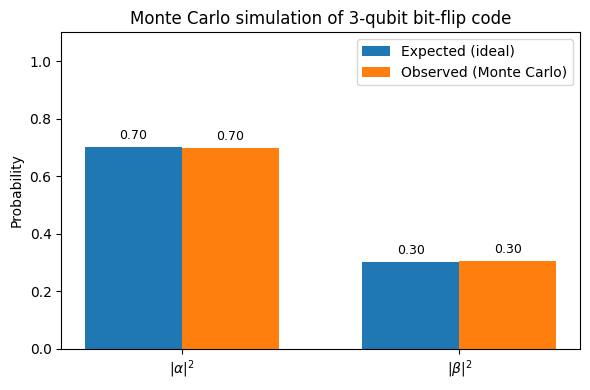

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
import random
import matplotlib.pyplot as plt

# Simulator
simulator = AerSimulator()

# Fixed alpha, beta (so alpha^2 + beta^2 = 1)
alpha, beta = np.sqrt(0.7), np.sqrt(0.3)
expected_probs = {'0': alpha**2, '1': beta**2}

# Monte Carlo simulation parameters
num_trials = 50   # number of random runs
shots = 1000
results_list = []

for trial in range(num_trials):

    # Step 1 - Registers
    data = QuantumRegister(3,'data')
    ancilla = QuantumRegister(2,'ancilla')
    syndrome = ClassicalRegister(2,'syndrome')
    output = ClassicalRegister(1,'Output')
    qc = QuantumCircuit(data,ancilla,syndrome,output)

    # Step 2 - Encoding
    qc.initialize([alpha,beta],data[0])
    qc.cx(data[0],data[1])
    qc.cx(data[0],data[2])

    # Step 3 - Random error
    error_qubit = random.randint(0,3)
    if error_qubit < 3:
        qc.x(data[error_qubit])
    # optional: comment the print for cleaner loops

    # Step 4 - Syndrome detection
    qc.cx(data[0],ancilla[0])
    qc.cx(data[2],ancilla[0])
    qc.cx(data[1],ancilla[1])
    qc.cx(data[2],ancilla[1])
    qc.barrier()
    qc.measure(ancilla[0], syndrome[0])
    qc.measure(ancilla[1], syndrome[1])

    # Step 5 - Correction
    with qc.if_test((syndrome, 0b01)):  # Error on data[0]
        qc.x(data[0])
    with qc.if_test((syndrome, 0b10)):  # Error on data[1]
        qc.x(data[1])
    with qc.if_test((syndrome, 0b11)):  # Error on data[2]
        qc.x(data[2])

    # Step 6 - Decoding
    qc.cx(data[0], data[2])
    qc.cx(data[0], data[1])
    qc.measure(data[0], output[0])

    # Run circuit
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts(qc)

    # Extract results
    output_counts = {'0': 0, '1': 0}
    for key, val in counts.items():
        output_bit = key.split()[0] if ' ' in key else key[-1]
        output_counts[output_bit] += val
    total = sum(output_counts.values())

    # Normalize to probabilities
    prob_0 = output_counts['0'] / total
    prob_1 = output_counts['1'] / total
    results_list.append((prob_0, prob_1))

# Average over all trials
avg_prob_0 = np.mean([r[0] for r in results_list])
avg_prob_1 = np.mean([r[1] for r in results_list])

# --- Plotting ---
labels = [r'$|\alpha|^2$', r'$|\beta|^2$']
expected = [expected_probs['0'], expected_probs['1']]
observed = [avg_prob_0, avg_prob_1]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
bars1 = ax.bar(x - width/2, expected, width, label='Expected (ideal)')
bars2 = ax.bar(x + width/2, observed, width, label='Observed (Monte Carlo)')

ax.set_ylabel('Probability')
ax.set_title('Monte Carlo simulation of 3-qubit bit-flip code')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0,1.1)

# Annotate bars with values
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


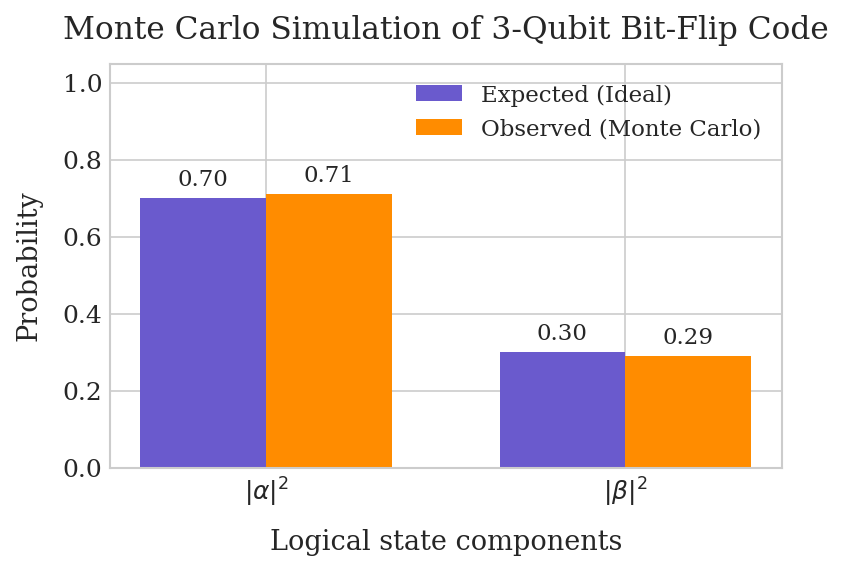

In [5]:
# --- Monte Carlo Simulation of 3-Qubit Bit-Flip Code ---
# (Research-style visualization)

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
import random
import matplotlib.pyplot as plt

# Use a high-quality style for research-paper-like plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 13,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 150
})

# Simulator
simulator = AerSimulator()

# Fixed state parameters (|ψ⟩ = α|0⟩ + β|1⟩)
alpha, beta = np.sqrt(0.7), np.sqrt(0.3)
expected_probs = {'0': alpha**2, '1': beta**2}

# Monte Carlo parameters
num_trials = 50
shots = 100
results_list = []

for trial in range(num_trials):
    # Step 1 - Registers
    data = QuantumRegister(3, 'data')
    ancilla = QuantumRegister(2, 'ancilla')
    syndrome = ClassicalRegister(2, 'syndrome')
    output = ClassicalRegister(1, 'Output')
    qc = QuantumCircuit(data, ancilla, syndrome, output)

    # Step 2 - Encoding
    qc.initialize([alpha, beta], data[0])
    qc.cx(data[0], data[1])
    qc.cx(data[0], data[2])

    # Step 3 - Random bit-flip error
    error_qubit = random.randint(0, 3)
    if error_qubit < 3:
        qc.x(data[error_qubit])

    # Step 4 - Syndrome extraction
    qc.cx(data[0], ancilla[0])
    qc.cx(data[2], ancilla[0])
    qc.cx(data[1], ancilla[1])
    qc.cx(data[2], ancilla[1])
    qc.barrier()
    qc.measure(ancilla[0], syndrome[0])
    qc.measure(ancilla[1], syndrome[1])

    # Step 5 - Conditional correction
    with qc.if_test((syndrome, 0b01)):
        qc.x(data[0])
    with qc.if_test((syndrome, 0b10)):
        qc.x(data[1])
    with qc.if_test((syndrome, 0b11)):
        qc.x(data[2])

    # Step 6 - Decoding and measurement
    qc.cx(data[0], data[2])
    qc.cx(data[0], data[1])
    qc.measure(data[0], output[0])

    # Simulation
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts(qc)

    # Compute normalized probabilities
    output_counts = {'0': 0, '1': 0}
    for key, val in counts.items():
        output_bit = key.split()[0] if ' ' in key else key[-1]
        output_counts[output_bit] += val
    total = sum(output_counts.values())
    prob_0 = output_counts['0'] / total
    prob_1 = output_counts['1'] / total

    results_list.append((prob_0, prob_1))

# --- Averaging over trials ---
avg_prob_0 = np.mean([r[0] for r in results_list])
avg_prob_1 = np.mean([r[1] for r in results_list])

# --- Visualization ---
labels = [r'$|\alpha|^2$', r'$|\beta|^2$']
expected = [expected_probs['0'], expected_probs['1']]
observed = [avg_prob_0, avg_prob_1]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(5.5, 4))
bars1 = ax.bar(x - width/2, expected, width, color='#6A5ACD', label='Expected (Ideal)')
bars2 = ax.bar(x + width/2, observed, width, color='#FF8C00', label='Observed (Monte Carlo)')

# Aesthetic details
ax.set_ylabel('Probability', labelpad=10)
ax.set_xlabel('Logical state components', labelpad=10)
ax.set_title('Monte Carlo Simulation of 3-Qubit Bit-Flip Code', pad=12)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.legend(frameon=False)

# Annotate bars with values
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}',
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


=== Circuit WITH error correction ===
❌ Error injected in qubit data[2]

🔧 Quantum Circuit Diagram with Error Correction:


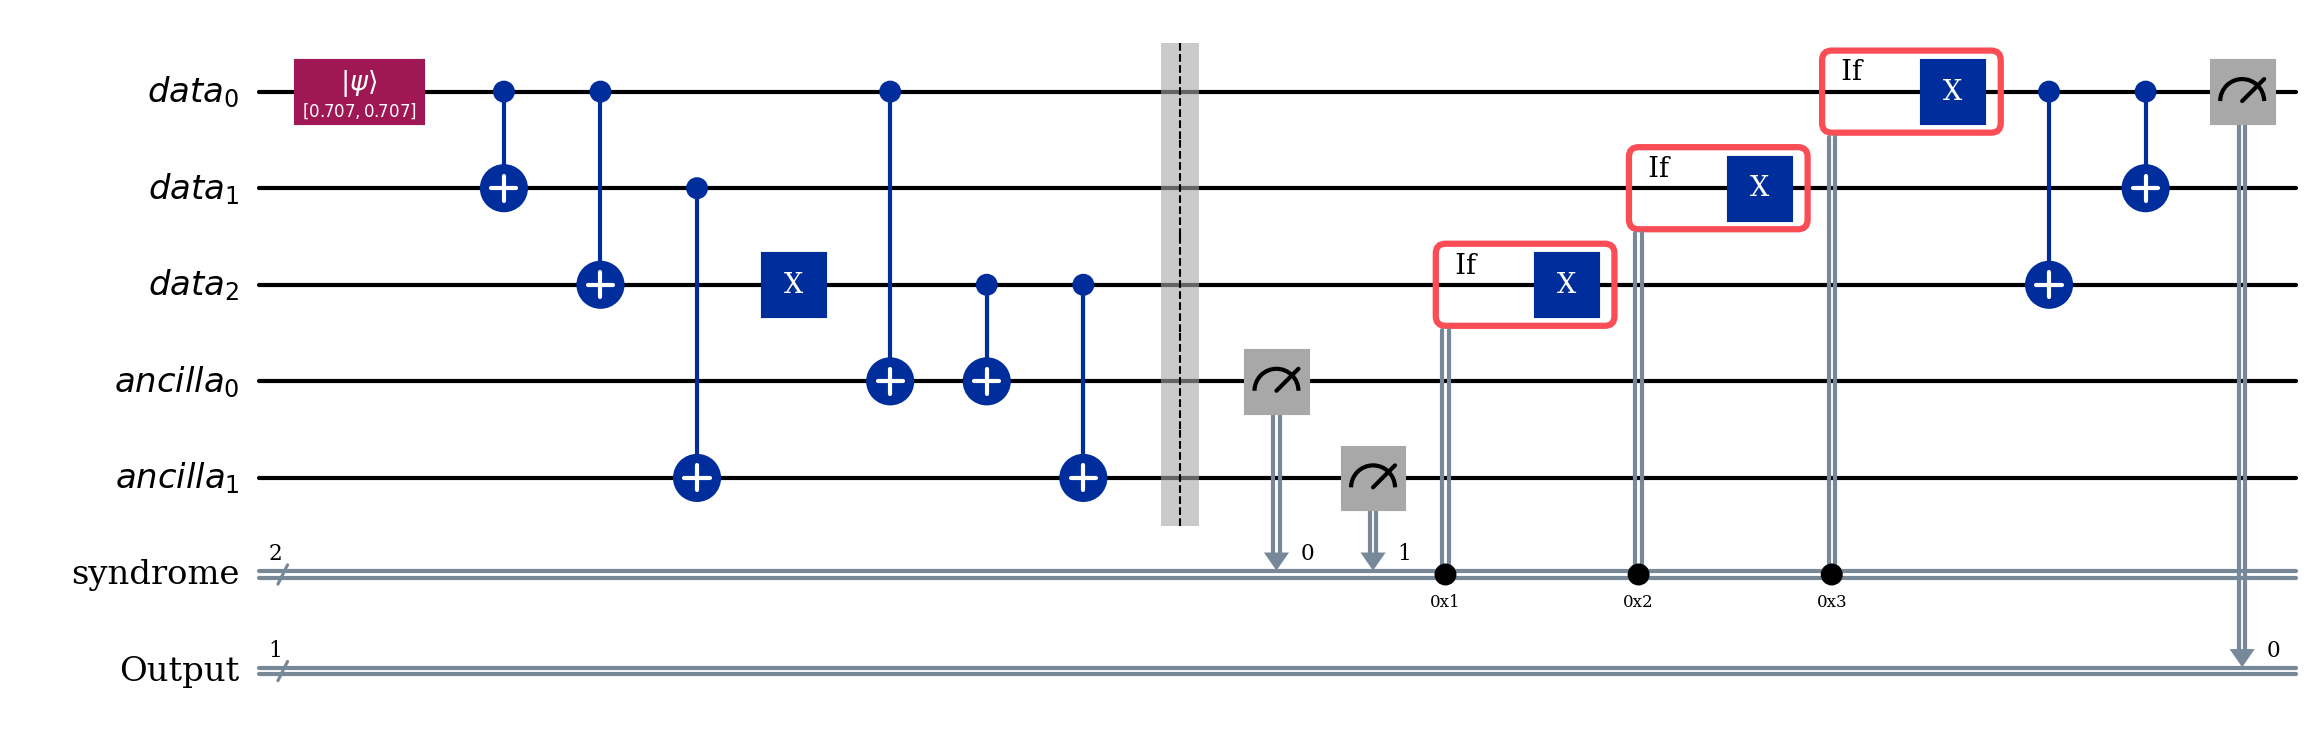

NameError: name 'qc_uncorrected' is not defined

In [6]:
# Install Qiskit and visualization tools
!pip install qiskit qiskit-aer qiskit[visualization] --quiet

# Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import numpy as np
import random
import matplotlib.pyplot as plt

def bit_flip_code_circuit(inject_error=True, do_correction=True):
    """
    Build a 3-qubit bit-flip code circuit.
    If inject_error=True, randomly inject a bit-flip error on one data qubit or no error.
    If do_correction=True, do syndrome measurement and correction, else just decode.
    """
    data = QuantumRegister(3, 'data')
    ancilla = QuantumRegister(2, 'ancilla')
    syndrome = ClassicalRegister(2, 'syndrome')
    output = ClassicalRegister(1, 'Output')
    qc = QuantumCircuit(data, ancilla, syndrome, output)

    # Encoding logical qubit |ψ> = sqrt(0.7)|0> + sqrt(0.3)|1>
    alpha, beta = np.sqrt(0.5), np.sqrt(0.5)
    qc.initialize([alpha, beta], data[0])
    qc.cx(data[0], data[1])
    qc.cx(data[0], data[2])

    # Inject error randomly on one qubit or none
    error_qubit = random.randint(0, 3)
    if inject_error and error_qubit < 3:
        qc.x(data[error_qubit])
        print(f"❌ Error injected in qubit data[{error_qubit}]")
    else:
        print("✅ No error injected")

    if do_correction:
        # Syndrome measurement
        qc.cx(data[0], ancilla[0])
        qc.cx(data[2], ancilla[0])
        qc.cx(data[1], ancilla[1])
        qc.cx(data[2], ancilla[1])
        qc.barrier()
        qc.measure(ancilla[0], syndrome[0])
        qc.measure(ancilla[1], syndrome[1])

        # Error correction
        with qc.if_test((syndrome, 0b01)): qc.x(data[2])
        with qc.if_test((syndrome, 0b10)): qc.x(data[1])
        with qc.if_test((syndrome, 0b11)): qc.x(data[0])

    # Decoding
    qc.cx(data[0], data[2])
    qc.cx(data[0], data[1])
    qc.measure(data[0], output[0])

    return qc

# --- Build circuits ---
print("=== Circuit WITH error correction ===")
qc_corrected = bit_flip_code_circuit(inject_error=True, do_correction=True)



# Draw the corrected circuit
print("\n🔧 Quantum Circuit Diagram with Error Correction:")
display(qc_corrected.draw('mpl'))

# Simulator
simulator = AerSimulator()

# Run simulations
shots = 10000
result_corrected = simulator.run(qc_corrected, shots=shots).result()
counts_corrected = result_corrected.get_counts()

result_uncorrected = simulator.run(qc_uncorrected, shots=shots).result()
counts_uncorrected = result_uncorrected.get_counts()

# Extract output measurement counts (last bit in keys)
def extract_output_counts(full_counts):
    output_counts = {'0': 0, '1': 0}
    for key, count in full_counts.items():
        output_bit = key[-1]  # fixed here: get last char, not splitting string
        output_counts[output_bit] += count
    return output_counts

output_corrected = extract_output_counts(counts_corrected)
output_uncorrected = extract_output_counts(counts_uncorrected)



# Plot side-by-side histograms
plot_histogram([output_uncorrected, output_corrected],
               legend=['No Error Correction', 'With Error Correction'],
               title="Comparison of Bit-Flip Error Correction Performance")
plt.show()


In [7]:
from qiskit.quantum_info import Statevector, partial_trace

def bit_flip_code_with_statevector(alpha=np.sqrt(0.7), beta=np.sqrt(0.3), inject_error=True):
    data = QuantumRegister(3, 'data')
    ancilla = QuantumRegister(2, 'ancilla')
    syndrome = ClassicalRegister(2, 'syndrome')
    output = ClassicalRegister(1, 'Output')
    qc = QuantumCircuit(data, ancilla, syndrome, output)

    # Encode
    qc.initialize([alpha, beta], data[0])
    qc.cx(data[0], data[1])
    qc.cx(data[0], data[2])

    # Inject error
    error_qubit = random.randint(0, 3)
    if inject_error and error_qubit < 3:
        qc.x(data[error_qubit])
        print(f"❌ Error injected in qubit data[{error_qubit}]")
    else:
        print("✅ No error injected")

    # Syndrome measurement & correction
    qc.cx(data[0], ancilla[0])
    qc.cx(data[2], ancilla[0])
    qc.cx(data[1], ancilla[1])
    qc.cx(data[2], ancilla[1])
    qc.barrier()
    qc.measure(ancilla[0], syndrome[0])
    qc.measure(ancilla[1], syndrome[1])

    with qc.if_test((syndrome, 0b01)): qc.x(data[2])
    with qc.if_test((syndrome, 0b10)): qc.x(data[1])
    with qc.if_test((syndrome, 0b11)): qc.x(data[0])

    # Decode
    qc.cx(data[0], data[2])
    qc.cx(data[0], data[1])

    # Save statevector before measurement
    qc.save_statevector(label='final_state')

    # Simulate
    sim = AerSimulator()
    result = sim.run(qc).result()
    statevec = result.data()['final_state']

    # Reduced density matrix for first qubit (logical qubit)
    logical_dm = partial_trace(statevec, [1, 2])  # trace out qubits 1 & 2
    alpha_beta = logical_dm.data.diagonal()  # populations
    print("\n🔹 Logical qubit before measurement (reduced density matrix):")
    print(np.round(logical_dm.data, 3))
    print("Approximate state amplitudes (α, β):", np.round(np.sqrt(np.real(alpha_beta)), 3))

    return qc, logical_dm


In [8]:
qc, logical_dm = bit_flip_code_with_statevector(alpha=np.sqrt(0.6), beta=np.sqrt(0.4), inject_error=True)


❌ Error injected in qubit data[2]

🔹 Logical qubit before measurement (reduced density matrix):
[[0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.4 +0.j 0.49+0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.49+0.j 0.6 +0.j]]
Approximate state amplitudes (α, β): [0.    0.    0.    0.    0.    0.    0.632 0.775]


In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np
import random

# User-defined parameters
alpha = np.sqrt(0.4)  # |0> state
beta = np.sqrt(0.6)
bit_flip_prob = 0.5
phase_flip_prob = 0.5

# Check normalization
norm = abs(alpha)**2 + abs(beta)**2
if not np.isclose(norm, 1.0, atol=1e-6):
    raise ValueError(f"State not normalized: |alpha|^2 + |beta|^2 = {norm}, expected 1.0")

# Initialize registers
data = QuantumRegister(9, 'data')
bit_syndrome = QuantumRegister(6, 'bit_syndrome')
phase_syndrome = QuantumRegister(2, 'phase_syndrome')
bit_meas = ClassicalRegister(6, 'bit_meas')
phase_meas = ClassicalRegister(2, 'phase_meas')
output_meas = ClassicalRegister(1, 'output')
qc = QuantumCircuit(data, bit_syndrome, phase_syndrome, bit_meas, phase_meas, output_meas)

# Step 1: Initialize logical qubit with alpha|0> + beta|1>
qc.initialize([alpha, beta], data[0])

# Step 2: Encode the logical qubit into Shor's 9-qubit code
# Phase-flip encoding
qc.cx(data[0], data[3])
qc.cx(data[0], data[6])
qc.h(data[0])
qc.h(data[3])
qc.h(data[6])
# Bit-flip encoding
qc.cx(data[0], data[1])
qc.cx(data[0], data[2])
qc.cx(data[3], data[4])
qc.cx(data[3], data[5])
qc.cx(data[6], data[7])
qc.cx(data[6], data[8])

qc.barrier()

# Step 3: Simulate random errors
#error_qubit = random.randint(0, 8)
error_qubit = 8
error_info = f"Errors introduced on data[{error_qubit}]: "
bit_flip = random.random() < bit_flip_prob
phase_flip = random.random() < phase_flip_prob
if bit_flip:
    qc.x(data[error_qubit])
    error_info += "Bit-flip (X) "
if phase_flip:
    qc.z(data[error_qubit])
    error_info += "Phase-flip (Z) "
if not (bit_flip or phase_flip):
    error_info += "None"

# Extra- One more error on Y
print(error_info)

qc.barrier()

# Step 4: Syndrome measurement for bit-flip errors
# Reset syndrome qubits

#qc.reset(bit_syndrome)

# Block 1: data[0,1,2]
qc.cx(data[0], bit_syndrome[0])
qc.cx(data[2], bit_syndrome[0])
qc.cx(data[1], bit_syndrome[1])
qc.cx(data[2], bit_syndrome[1])
# Block 2: data[3,4,5]
qc.cx(data[3], bit_syndrome[2])
qc.cx(data[5], bit_syndrome[2])
qc.cx(data[4], bit_syndrome[3])
qc.cx(data[5], bit_syndrome[3])

# Block 3: data[6,7,8]
qc.cx(data[6], bit_syndrome[4])
qc.cx(data[8], bit_syndrome[4])
qc.cx(data[7], bit_syndrome[5])
qc.cx(data[8], bit_syndrome[5])

# Measure bit-flip syndromes
qc.measure(bit_syndrome[0], bit_meas[0])
qc.measure(bit_syndrome[1], bit_meas[1])
qc.measure(bit_syndrome[2], bit_meas[2])
qc.measure(bit_syndrome[3], bit_meas[3])
qc.measure(bit_syndrome[4], bit_meas[4])
qc.measure(bit_syndrome[5], bit_meas[5])


# Correct bit-flip errors
# Block 1: 10 -> flip data[0], 01 -> flip data[2], 11 -> flip data[1]
with qc.if_test((bit_meas, 0b10)) as else_:
    qc.x(data[0])
with else_:
    with qc.if_test((bit_meas, 0b01)):
        qc.x(data[1])
    with qc.if_test((bit_meas, 0b11)):
        qc.x(data[2])
# Block 2: 10 -> flip data[3], 01 -> flip data[5], 11 -> flip data[4]
with qc.if_test((bit_meas, 0b10)) as else_:
    qc.x(data[3])
with else_:
    with qc.if_test((bit_meas, 0b01)):
        qc.x(data[4])
    with qc.if_test((bit_meas, 0b11)):
        qc.x(data[5])

# Block 2: 10 -> flip data[3], 01 -> flip data[5], 11 -> flip data[4]
with qc.if_test((bit_meas, 0b10)) as else_:
    qc.x(data[6])
with else_:
    with qc.if_test((bit_meas, 0b01)):
        qc.x(data[7])
    with qc.if_test((bit_meas, 0b11)):
        qc.x(data[8])


qc.barrier()

# Step 5: Syndrome measurement for phase-flip errors
# Reset syndrome qubits
#qc.reset(phase_syndrome)

qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.h(data[3])
qc.h(data[4])
qc.h(data[5])
qc.h(data[6])
qc.h(data[7])
qc.h(data[8])

qc.cx(data[0], phase_syndrome[0])
qc.cx(data[1], phase_syndrome[0])
qc.cx(data[2], phase_syndrome[0])
qc.cx(data[3], phase_syndrome[0])
qc.cx(data[4], phase_syndrome[0])
qc.cx(data[5], phase_syndrome[0])

qc.cx(data[3], phase_syndrome[1])
qc.cx(data[4], phase_syndrome[1])
qc.cx(data[5], phase_syndrome[1])
qc.cx(data[6], phase_syndrome[1])
qc.cx(data[7], phase_syndrome[1])
qc.cx(data[8], phase_syndrome[1])

qc.cx(phase_syndrome[0],phase_syndrome[1])
# Transform back

qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.h(data[3])
qc.h(data[4])
qc.h(data[5])
qc.h(data[6])
qc.h(data[7])
qc.h(data[8])

# Measure phase differences between blocks
qc.measure(phase_syndrome[0], phase_meas[0])
qc.measure(phase_syndrome[1], phase_meas[1])


'''
# Correct phase-flip errors
# 10 -> flip data[0], 01 -> flip data[6], 11 -> flip data[3]
with qc.if_test((phase_meas, 0b10)) as else_:
    qc.z(data[0])
with else_:
    with qc.if_test((phase_meas, 0b01)):
        qc.z(data[6])
    with qc.if_test((phase_meas, 0b11)):
        qc.z(data[3])
'''

# Step 5: Syndrome measurement for phase-flip errors
qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.h(data[3])
qc.h(data[4])
qc.h(data[5])
qc.h(data[6])
qc.h(data[7])
qc.h(data[8])

qc.cx(data[0], phase_syndrome[0])
qc.cx(data[1], phase_syndrome[0])
qc.cx(data[2], phase_syndrome[0])
qc.cx(data[3], phase_syndrome[0])
qc.cx(data[4], phase_syndrome[0])
qc.cx(data[5], phase_syndrome[0])

qc.cx(data[3], phase_syndrome[1])
qc.cx(data[4], phase_syndrome[1])
qc.cx(data[5], phase_syndrome[1])
qc.cx(data[6], phase_syndrome[1])
qc.cx(data[7], phase_syndrome[1])
qc.cx(data[8], phase_syndrome[1])

qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.h(data[3])
qc.h(data[4])
qc.h(data[5])
qc.h(data[6])
qc.h(data[7])
qc.h(data[8])

# Measure phase differences between blocks
qc.measure(phase_syndrome[0], phase_meas[0])
qc.measure(phase_syndrome[1], phase_meas[1])

# Correct phase-flip errors - APPLY TO ALL QUBITS IN THE AFFECTED BLOCK
with qc.if_test((phase_meas, 0b10)):  # First block has phase flip
    qc.z(data[0])
    qc.z(data[1])
    qc.z(data[2])
with qc.if_test((phase_meas, 0b01)):  # Third block has phase flip
    qc.z(data[6])
    qc.z(data[7])
    qc.z(data[8])
with qc.if_test((phase_meas, 0b11)):  # Second block has phase flip
    qc.z(data[3])
    qc.z(data[4])
    qc.z(data[5])


qc.barrier()

# Step 6: Decode the logical qubit
# Reverse bit-flip encoding
qc.cx(data[0], data[2])
qc.cx(data[0], data[1])
qc.cx(data[3], data[5])
qc.cx(data[3], data[4])
qc.cx(data[6], data[8])
qc.cx(data[6], data[7])
# Reverse phase-flip encoding
qc.h(data[6])
qc.h(data[3])
qc.h(data[0])
qc.cx(data[0], data[6])
qc.cx(data[0], data[3])



# Measure the logical qubit
qc.measure(data[0], output_meas[0])


# Execute the circuit
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts()

# Count 0s and 1s for the logical qubit
zero_count = sum(v for k, v in counts.items() if k.split()[0] == '0')
one_count = sum(v for k, v in counts.items() if k.split()[0] == '1')




# Print results
print("Measurement outcomes:", counts)
print(f"Number of 0s: {zero_count}")
print(f"Number of 1s: {one_count}")


Errors introduced on data[8]: Bit-flip (X) Phase-flip (Z) 
Measurement outcomes: {'1 00 110000': 616, '0 00 110000': 408}
Number of 0s: 408
Number of 1s: 616


In [11]:
from qiskit.visualization import plot_bloch_multivector

In [12]:
some_state=[1,0]

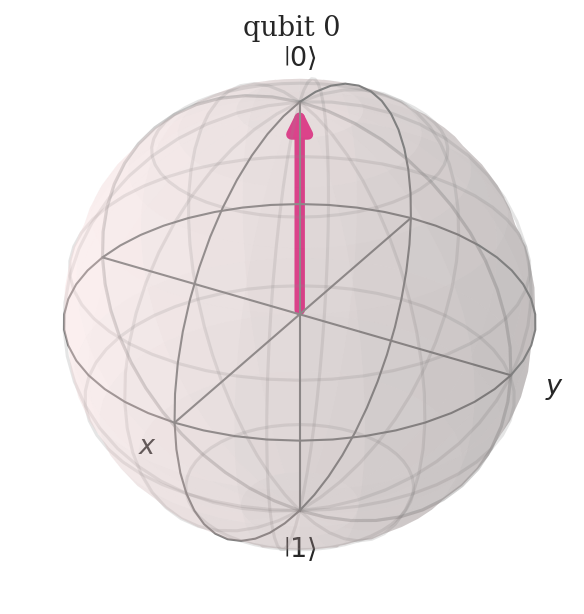

In [13]:
plot_bloch_multivector(some_state)

In [14]:
import math
epsilon = 0.1
noisy_state = [math.cos(epsilon), 1j * math.sin(epsilon)]


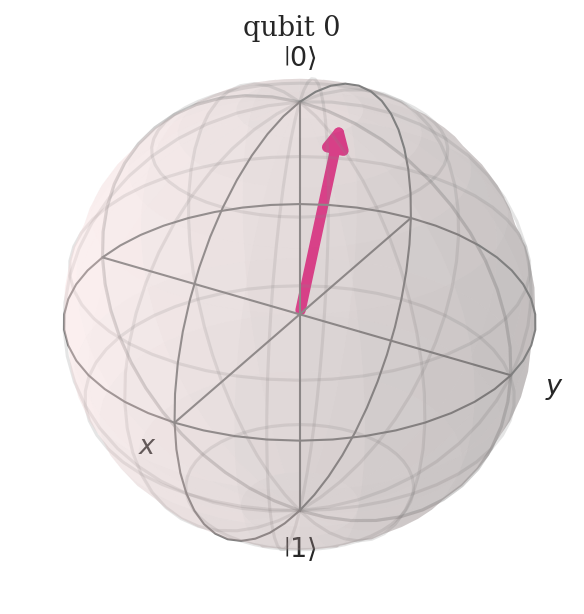

In [15]:
plot_bloch_multivector(noisy_state)

Dephasing evolution (rho for |+> state):

p = 0.00:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

p = 0.20:
[[0.5+0.j 0.4+0.j]
 [0.4+0.j 0.5+0.j]]

p = 0.40:
[[0.5+0.j 0.3+0.j]
 [0.3+0.j 0.5+0.j]]

p = 0.60:
[[0.5+0.j 0.2+0.j]
 [0.2+0.j 0.5+0.j]]

p = 0.80:
[[0.5+0.j 0.1+0.j]
 [0.1+0.j 0.5+0.j]]

p = 1.00:
[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]



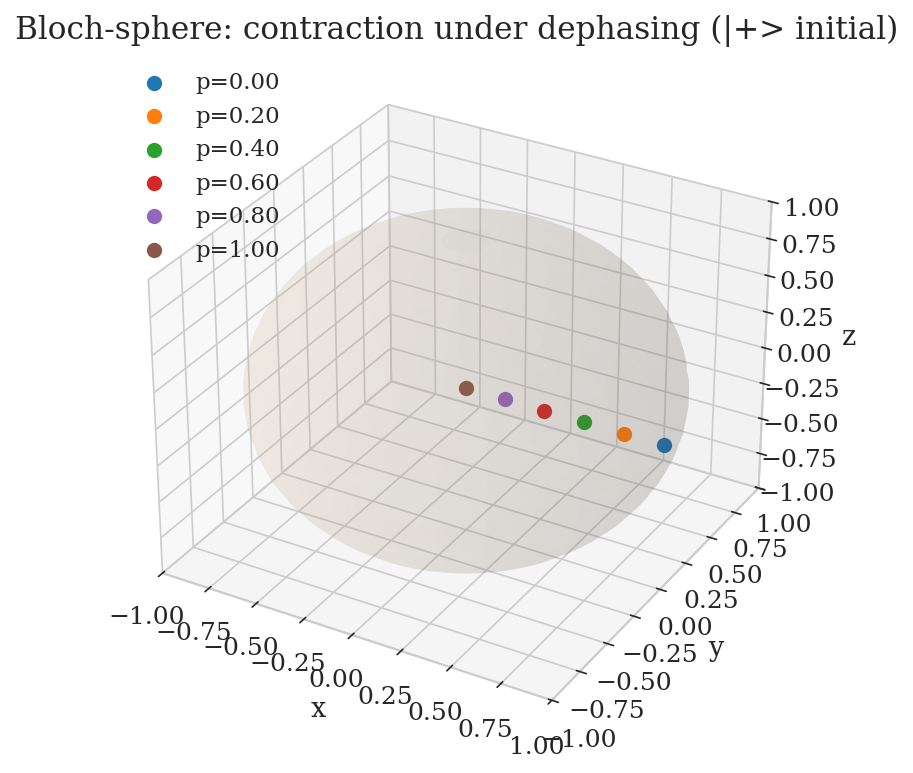

Off-diagonal magnitude |rho_01| vs p:
p=0.00, |rho_01|=0.5000
p=0.20, |rho_01|=0.4000
p=0.40, |rho_01|=0.3000
p=0.60, |rho_01|=0.2000
p=0.80, |rho_01|=0.1000
p=1.00, |rho_01|=0.0000

Observation:
- Populations (diagonal terms) remain constant.
- Coherences (off-diagonals) decay with (1 - p).
- Bloch vector shrinks toward z-axis, visualizing decoherence.


In [16]:
# --- Environmental Decoherence (Pure Dephasing) Visualization ---
# Author: [Your Name]
# Purpose: Demonstrate decoherence using Kraus operators and Bloch-sphere contraction.

# === Required Packages ===
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === Define Basic Quantum Objects ===
# Pauli matrices
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
I = np.eye(2, dtype=complex)

# Computational basis
zero = np.array([[1],[0]], dtype=complex)
one  = np.array([[0],[1]], dtype=complex)

# --- Helper Functions ---
def dm(psi):
    """Create a density matrix from a state vector."""
    return psi @ psi.conj().T

def bloch_vector(rho):
    """Compute Bloch vector (rx, ry, rz) from density matrix."""
    rx = np.trace(rho @ X).real
    ry = np.trace(rho @ Y).real
    rz = np.trace(rho @ Z).real
    return np.array([rx, ry, rz])

def dephasing_kraus(p):
    """Return Kraus operators for pure dephasing channel with probability p."""
    K0 = np.sqrt(1 - p) * I
    K1 = np.sqrt(p) * np.array([[1,0],[0,0]], dtype=complex)
    K2 = np.sqrt(p) * np.array([[0,0],[0,1]], dtype=complex)
    return [K0, K1, K2]

def apply_channel(rho, kraus_ops):
    """Apply a quantum channel defined by Kraus operators."""
    out = np.zeros_like(rho, dtype=complex)
    for K in kraus_ops:
        out += K @ rho @ K.conj().T
    return out

# --- Initial States ---
plus = (zero + one) / np.sqrt(2)   # |+> = (|0> + |1>)/sqrt(2)
rho_plus = dm(plus)

# --- Simulate Dephasing ---
ps = np.linspace(0, 1, 6)
rhos = []
print("Dephasing evolution (rho for |+> state):\n")
for p in ps:
    rho_p = apply_channel(rho_plus, dephasing_kraus(p))
    rhos.append(rho_p)
    print(f"p = {p:.2f}:\n{np.round(rho_p,3)}\n")

# --- Compute Bloch Vectors ---
bloch_points = [bloch_vector(r) for r in rhos]

# --- Plot Bloch Sphere Contraction ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Bloch sphere surface
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(x, y, z, color='tan', alpha=0.1)

# Axes setup
ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title('Bloch-sphere: contraction under dephasing (|+> initial)')

# Plot states for different p values
for i, bp in enumerate(bloch_points):
    ax.scatter(bp[0], bp[1], bp[2], s=40, label=f"p={ps[i]:.2f}")
ax.legend()

plt.show()

# --- Analyze Coherence Loss ---
print("Off-diagonal magnitude |rho_01| vs p:")
for p, rho_p in zip(ps, rhos):
    off_diag = abs(rho_p[0,1])
    print(f"p={p:.2f}, |rho_01|={off_diag:.4f}")

print("\nObservation:")
print("- Populations (diagonal terms) remain constant.")
print("- Coherences (off-diagonals) decay with (1 - p).")
print("- Bloch vector shrinks toward z-axis, visualizing decoherence.")


In [17]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
import random

#Step 1 - Intialising Registers
data = QuantumRegister(3,'data')
ancilla = QuantumRegister(2,'ancilla')
syndrome = ClassicalRegister(2,'syndrome')
output = ClassicalRegister(1,'Output')
qc = QuantumCircuit(data,ancilla,syndrome,output)

#Step 2 - Encoding
alpha, beta = 0, 1
qc.initialize([alpha,beta],data[0])
qc.cx(data[0],data[1])
qc.cx(data[0],data[2])
qc.h(data[0])
qc.h(data[1])
qc.h(data[2])




#Step 3 - Error inducing
error_qubit = random.randint(0,3)
if error_qubit < 3:
    qc.z(data[error_qubit])
    print(f"Error injected in qubit data[{error_qubit}]")

else:
    print("No error injected")


#Step 4 - Reciever - Detecting and C
qc.h(data[2])
qc.h(data[1])
qc.h(data[0])

qc.cx(data[0],ancilla[0])
qc.cx(data[2],ancilla[0])
qc.cx(data[1], ancilla[1])
qc.cx(data[2], ancilla[1])
qc.barrier()
qc.measure(ancilla[0], syndrome[0]) # syndrome[0] = q0 XOR q2 (LSB)
qc.measure(ancilla[1], syndrome[1]) # syndrome[1] = q1 XOR q2 (MSB)


qc.h(data[0])
qc.h(data[1])
qc.h(data[2])

#Step 5 Error Correction
with qc.if_test((syndrome, 0b01)):  # '01' → Error on data[0]
    qc.z(data[0])
with qc.if_test((syndrome, 0b10)):  # '10' → Error on data[1]
    qc.z(data[1])
with qc.if_test((syndrome, 0b11)):  # '11' → Error on data[2]
    qc.z(data[2])

#Step 6 Decoding
qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.cx(data[0],data[2])
qc.cx(data[0],data[1])

qc.measure(data[0], output[0])

#Circuit
simulator = AerSimulator()
result = simulator.run(qc, shots=10000).result()
counts = result.get_counts()

#Result
output_counts = {'0': 0, '1': 0}
for key in counts:
    # Extract the last bit (output[0])
    output_bit = key.split()[0] if ' ' in key else key[-1]
    output_counts[output_bit] += counts[key]

print("Output counts:", output_counts)
print("Syndrome counts:", result.get_counts(qc))


No error injected
Output counts: {'0': 0, '1': 10000}
Syndrome counts: {'1 00': 10000}


Analyzing single case with ε = 0.2
Initial state: |ψ⟩ = 0.837|0⟩ + 0.548|1⟩

Syndrome probabilities:
  Syndrome 00: 0.6463
  Syndrome 01: 0.0379
  Syndrome 10: 0.0379
  Syndrome 11: 0.2779

Fidelities for ε = 0.2:
  Encoded fidelity: 0.573685
  Unencoded fidelity: 0.993685
  Improvement factor: 0.577


Simulating coherent errors...
Progress: 1/20, ε = 0.000
Progress: 2/20, ε = 0.105
Progress: 3/20, ε = 0.211
Progress: 4/20, ε = 0.316
Progress: 5/20, ε = 0.421
Progress: 6/20, ε = 0.526
Progress: 7/20, ε = 0.632
Progress: 8/20, ε = 0.737
Progress: 9/20, ε = 0.842
Progress: 10/20, ε = 0.947
Progress: 11/20, ε = 1.053
Progress: 12/20, ε = 1.158
Progress: 13/20, ε = 1.263
Progress: 14/20, ε = 1.368
Progress: 15/20, ε = 1.474
Progress: 16/20, ε = 1.579
Progress: 17/20, ε = 1.684
Progress: 18/20, ε = 1.789
Progress: 19/20, ε = 1.895
Progress: 20/20, ε = 2.000


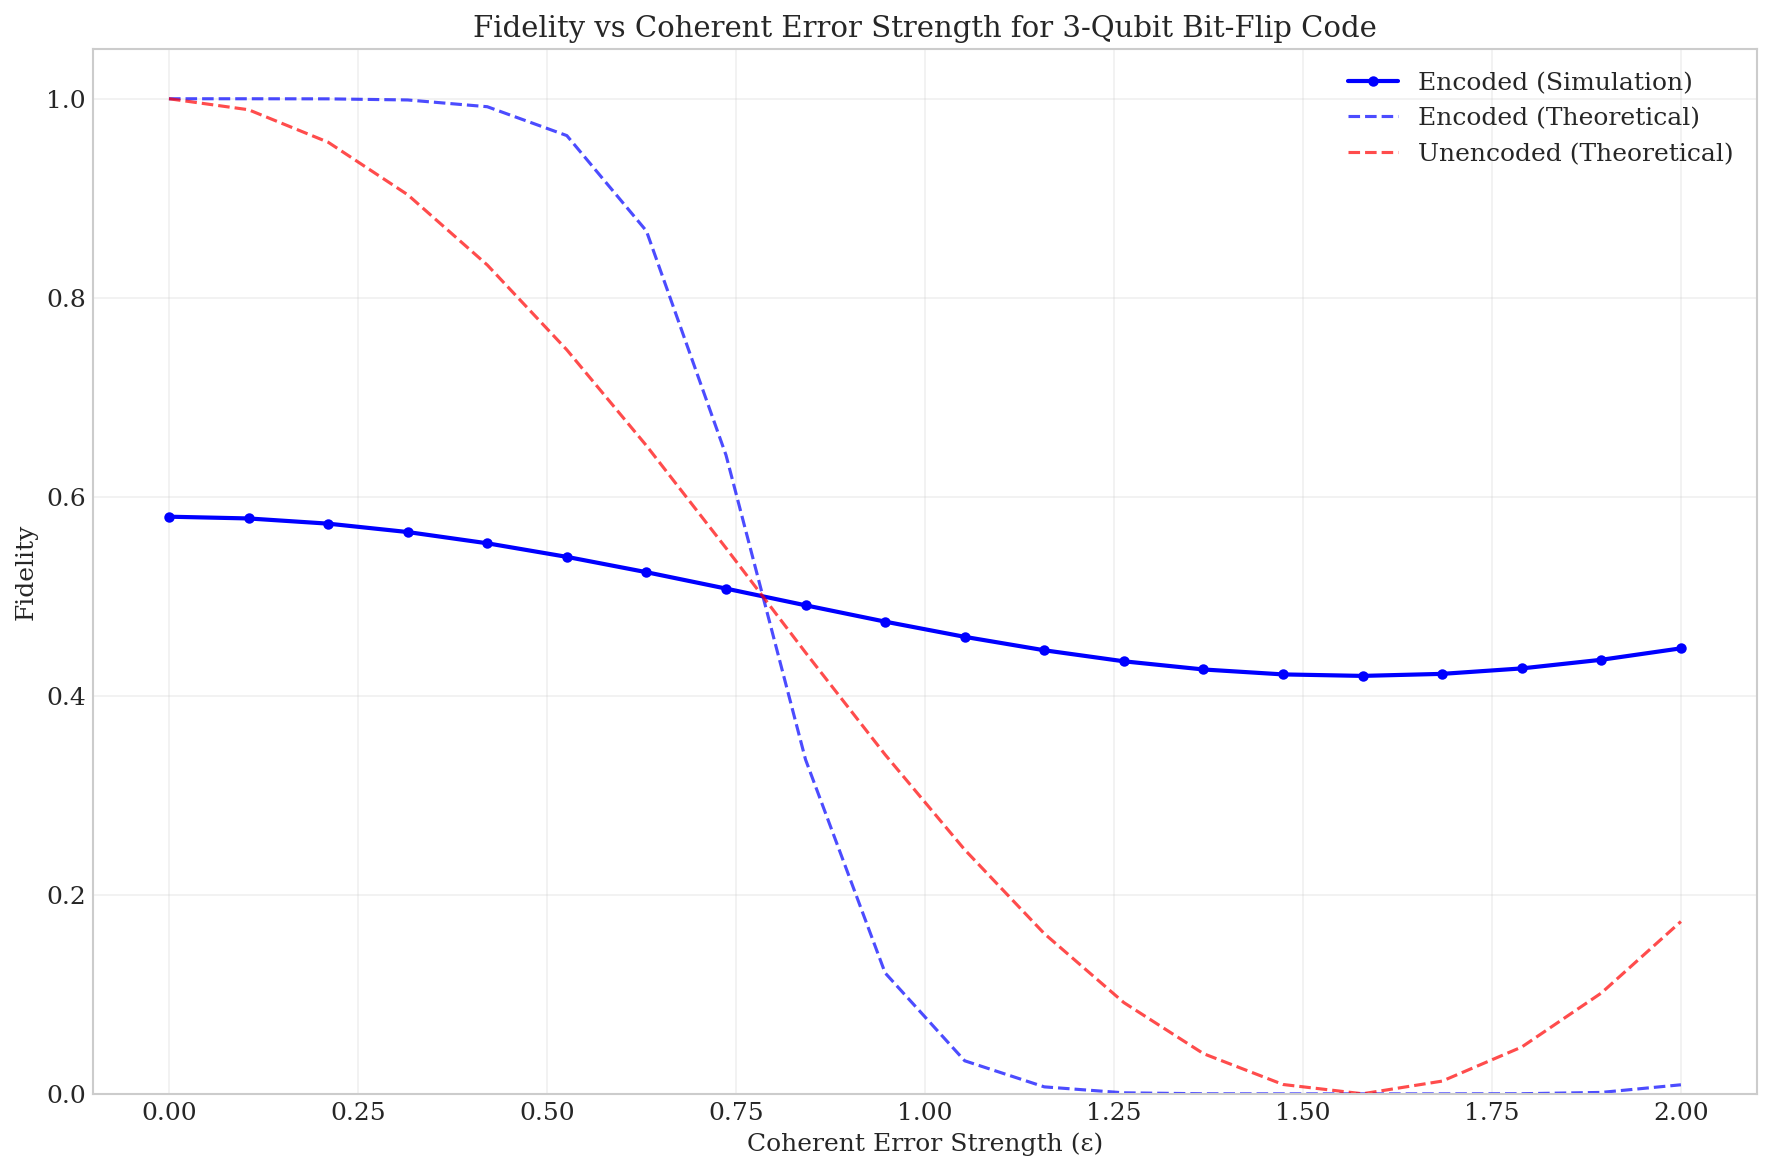


Fidelity Comparison for selected ε values:
ε	Encoded(Sim)	Encoded(Theo)	Unencoded(Sim)	Unencoded(Theo)
0.000	0.580000	1.000000	1.000000	1.000000
0.526	0.539623	0.962968	0.959623	0.747643
1.053	0.459249	0.033202	0.879249	0.245309
1.579	0.420011	0.000000	0.840011	0.000066


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.quantum_info import state_fidelity

def create_3qubit_code_circuit_no_measure(alpha, beta, epsilon):
    """
    Create a 3-qubit bit-flip code circuit with coherent errors
    without measurement for statevector simulation
    """
    data = QuantumRegister(3, 'data')
    ancilla = QuantumRegister(2, 'ancilla')
    qc = QuantumCircuit(data, ancilla)

    # Step 1 - Encoding
    qc.initialize([alpha, beta], data[0])
    qc.cx(data[0], data[1])
    qc.cx(data[0], data[2])

    # Step 2 - Apply coherent errors (rotation around X-axis on all qubits)
    for i in range(3):
        qc.rx(2 * epsilon, data[i])

    # Step 3 - Syndrome measurement circuit
    qc.cx(data[0], ancilla[0])
    qc.cx(data[2], ancilla[0])
    qc.cx(data[1], ancilla[1])
    qc.cx(data[2], ancilla[1])

    return qc

def manual_error_correction(statevector, syndrome):
    """
    Manually apply error correction based on syndrome measurement
    """
    corrected_state = statevector.copy()
    x_gate = np.array([[0, 1], [1, 0]])

    if syndrome == 0b01:  # Error on data[0]
        full_op = np.kron(x_gate, np.eye(16))
        corrected_state = Statevector(full_op @ corrected_state.data)
    elif syndrome == 0b10:  # Error on data[1]
        full_op = np.kron(np.eye(2), np.kron(x_gate, np.eye(8)))
        corrected_state = Statevector(full_op @ corrected_state.data)
    elif syndrome == 0b11:  # Error on data[2]
        full_op = np.kron(np.eye(4), np.kron(x_gate, np.eye(4)))
        corrected_state = Statevector(full_op @ corrected_state.data)

    return corrected_state

def compute_fidelity_coherent_error(alpha, beta, epsilon):
    """
    Compute fidelity for coherent error case using statevector simulation
    with manual syndrome projection and correction
    """
    # Ideal encoded state
    ideal_qc = QuantumCircuit(3)
    ideal_qc.initialize([alpha, beta], 0)
    ideal_qc.cx(0, 1)
    ideal_qc.cx(0, 2)
    ideal_state = Statevector(ideal_qc)

    # Circuit with coherent errors
    qc = create_3qubit_code_circuit_no_measure(alpha, beta, epsilon)
    full_state = Statevector(qc)

    total_fidelity = 0.0
    syndromes = [0b00, 0b01, 0b10, 0b11]

    for syndrome in syndromes:
        bit0 = (syndrome >> 0) & 1
        bit1 = (syndrome >> 1) & 1

        proj_ancilla0 = np.zeros((2, 2)); proj_ancilla0[bit0, bit0] = 1
        proj_ancilla1 = np.zeros((2, 2)); proj_ancilla1[bit1, bit1] = 1
        full_proj = np.kron(np.eye(8), np.kron(proj_ancilla0, proj_ancilla1))

        projected_state_data = full_proj @ full_state.data
        projected_norm = np.linalg.norm(projected_state_data)
        if projected_norm > 1e-10:
            projected_state = Statevector(projected_state_data / projected_norm)
            probability = projected_norm ** 2
            corrected_state = manual_error_correction(projected_state, syndrome)

            # Decoding (reverse of encoding)
            decoding_qc = QuantumCircuit(5)
            decoding_qc.cx(0, 2)
            decoding_qc.cx(0, 1)
            decoded_state = corrected_state.evolve(decoding_qc)

            # Trace out all but logical qubit
            final_logical_state = partial_trace(decoded_state, [1, 2, 3, 4])

            # Compute fidelity using Qiskit's built-in function
            ideal_single_qubit = Statevector([alpha, beta])
            fid = state_fidelity(ideal_single_qubit, final_logical_state)
            total_fidelity += probability * fid

    return total_fidelity  # Already a scalar

def compute_unencoded_fidelity(alpha, beta, epsilon):
    """
    Compute fidelity for unencoded qubit with coherent error
    """
    overlap = np.cos(epsilon) + 1j * np.sin(epsilon) * (alpha * np.conj(beta) + beta * np.conj(alpha))
    fidelity_val = np.abs(overlap) ** 2
    return np.real(fidelity_val)

def simulate_coherent_errors():
    alpha = np.sqrt(0.7)
    beta = np.sqrt(0.3)
    epsilon_values = np.linspace(0, 2, 20)

    encoded_fidelities = []
    unencoded_fidelities = []
    theoretical_encoded = []
    theoretical_unencoded = []

    print("Simulating coherent errors...")

    for i, epsilon in enumerate(epsilon_values):
        print(f"Progress: {i+1}/{len(epsilon_values)}, ε = {epsilon:.3f}")
        encoded_fid = compute_fidelity_coherent_error(alpha, beta, epsilon)
        unencoded_fid = compute_unencoded_fidelity(alpha, beta, epsilon)

        cos_eps = np.cos(epsilon); sin_eps = np.sin(epsilon)
        theo_encoded = (cos_eps ** 6) / (cos_eps ** 6 + sin_eps ** 6)
        theo_unencoded = cos_eps ** 2

        encoded_fidelities.append(encoded_fid)
        unencoded_fidelities.append(unencoded_fid)
        theoretical_encoded.append(theo_encoded)
        theoretical_unencoded.append(theo_unencoded)

    plt.figure(figsize=(12, 8))
    plt.plot(epsilon_values, encoded_fidelities, 'bo-', linewidth=2, markersize=4, label='Encoded (Simulation)')
    #plt.plot(epsilon_values, unencoded_fidelities, 'ro-', linewidth=2, markersize=4, label='Unencoded (Simulation)')
    plt.plot(epsilon_values, theoretical_encoded, 'b--', alpha=0.7, label='Encoded (Theoretical)')
    plt.plot(epsilon_values, theoretical_unencoded, 'r--', alpha=0.7, label='Unencoded (Theoretical)')

    plt.xlabel('Coherent Error Strength (ε)', fontsize=12)
    plt.ylabel('Fidelity', fontsize=12)
    plt.title('Fidelity vs Coherent Error Strength for 3-Qubit Bit-Flip Code', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    print("\nFidelity Comparison for selected ε values:")
    print("ε\tEncoded(Sim)\tEncoded(Theo)\tUnencoded(Sim)\tUnencoded(Theo)")
    for i in [0, 5, 10, 15]:
        eps = epsilon_values[i]
        print(f"{eps:.3f}\t{encoded_fidelities[i]:.6f}\t{theoretical_encoded[i]:.6f}\t"
              f"{unencoded_fidelities[i]:.6f}\t{theoretical_unencoded[i]:.6f}")

def analyze_single_case():
    alpha = np.sqrt(0.7)
    beta = np.sqrt(0.3)
    epsilon = 0.2
    print(f"Analyzing single case with ε = {epsilon}")
    print(f"Initial state: |ψ⟩ = {alpha:.3f}|0⟩ + {beta:.3f}|1⟩")

    qc = create_3qubit_code_circuit_no_measure(alpha, beta, epsilon)
    full_state = Statevector(qc)

    syndromes = [0b00, 0b01, 0b10, 0b11]
    syndrome_probs = {}

    for syndrome in syndromes:
        bit0 = (syndrome >> 0) & 1
        bit1 = (syndrome >> 1) & 1
        proj_ancilla0 = np.zeros((2, 2)); proj_ancilla0[bit0, bit0] = 1
        proj_ancilla1 = np.zeros((2, 2)); proj_ancilla1[bit1, bit1] = 1
        full_proj = np.kron(np.eye(8), np.kron(proj_ancilla0, proj_ancilla1))
        projected_state_data = full_proj @ full_state.data
        probability = np.linalg.norm(projected_state_data) ** 2
        syndrome_probs[syndrome] = probability

    print("\nSyndrome probabilities:")
    for syndrome, prob in syndrome_probs.items():
        print(f"  Syndrome {syndrome:02b}: {prob:.4f}")

    encoded_fid = compute_fidelity_coherent_error(alpha, beta, epsilon)
    unencoded_fid = compute_unencoded_fidelity(alpha, beta, epsilon)

    print(f"\nFidelities for ε = {epsilon}:")
    print(f"  Encoded fidelity: {encoded_fid:.6f}")
    print(f"  Unencoded fidelity: {unencoded_fid:.6f}")
    print(f"  Improvement factor: {encoded_fid/unencoded_fid:.3f}")

if __name__ == "__main__":
    analyze_single_case()
    print("\n" + "="*60 + "\n")
    simulate_coherent_errors()


In [19]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np
import random

# User-defined parameters
alpha = np.sqrt(0.2)  # |0> state
beta = np.sqrt(0.8)
bit_flip_prob = 0.5
phase_flip_prob = 0.5

# Check normalization
norm = abs(alpha)**2 + abs(beta)**2
if not np.isclose(norm, 1.0, atol=1e-6):
    raise ValueError(f"State not normalized: |alpha|^2 + |beta|^2 = {norm}, expected 1.0")

# Initialize registers
data = QuantumRegister(9, 'data')
bit_syndrome = QuantumRegister(6, 'bit_syndrome')
phase_syndrome = QuantumRegister(2, 'phase_syndrome')
bit_meas = ClassicalRegister(6, 'bit_meas')
phase_meas = ClassicalRegister(2, 'phase_meas')
output_meas = ClassicalRegister(1, 'output')
qc = QuantumCircuit(data, bit_syndrome, phase_syndrome, bit_meas, phase_meas, output_meas)

# Step 1: Initialize logical qubit with alpha|0> + beta|1>
qc.initialize([alpha, beta], data[0])

# Step 2: Encode the logical qubit into Shor's 9-qubit code
# Phase-flip encoding
qc.cx(data[0], data[3])
qc.cx(data[0], data[6])
qc.h(data[0])
qc.h(data[3])
qc.h(data[6])
# Bit-flip encoding
qc.cx(data[0], data[1])
qc.cx(data[0], data[2])
qc.cx(data[3], data[4])
qc.cx(data[3], data[5])
qc.cx(data[6], data[7])
qc.cx(data[6], data[8])

qc.barrier()

# Step 3: Simulate random errors
#error_qubit = random.randint(0, 8)
error_qubit = 8
error_info = f"Errors introduced on data[{error_qubit}]: "
bit_flip = random.random() < bit_flip_prob
phase_flip = random.random() < phase_flip_prob
if bit_flip:
    qc.x(data[error_qubit])
    error_info += "Bit-flip (X) "
if phase_flip:
    qc.z(data[error_qubit])
    error_info += "Phase-flip (Z) "
if not (bit_flip or phase_flip):
    error_info += "None"

# Extra- One more error on Y
print(error_info)

qc.barrier()

# Step 4: Syndrome measurement for bit-flip errors
# Reset syndrome qubits

#qc.reset(bit_syndrome)

# Block 1: data[0,1,2]
qc.cx(data[0], bit_syndrome[0])
qc.cx(data[2], bit_syndrome[0])
qc.cx(data[1], bit_syndrome[1])
qc.cx(data[2], bit_syndrome[1])
# Block 2: data[3,4,5]
qc.cx(data[3], bit_syndrome[2])
qc.cx(data[5], bit_syndrome[2])
qc.cx(data[4], bit_syndrome[3])
qc.cx(data[5], bit_syndrome[3])

# Block 3: data[6,7,8]
qc.cx(data[6], bit_syndrome[4])
qc.cx(data[8], bit_syndrome[4])
qc.cx(data[7], bit_syndrome[5])
qc.cx(data[8], bit_syndrome[5])

# Measure bit-flip syndromes
qc.measure(bit_syndrome[0], bit_meas[0])
qc.measure(bit_syndrome[1], bit_meas[1])
qc.measure(bit_syndrome[2], bit_meas[2])
qc.measure(bit_syndrome[3], bit_meas[3])
qc.measure(bit_syndrome[4], bit_meas[4])
qc.measure(bit_syndrome[5], bit_meas[5])


# Correct bit-flip errors
# Block 1: 10 -> flip data[0], 01 -> flip data[2], 11 -> flip data[1]
with qc.if_test((bit_meas, 0b10)) as else_:
    qc.x(data[0])
with else_:
    with qc.if_test((bit_meas, 0b01)):
        qc.x(data[1])
    with qc.if_test((bit_meas, 0b11)):
        qc.x(data[2])
# Block 2: 10 -> flip data[3], 01 -> flip data[5], 11 -> flip data[4]
with qc.if_test((bit_meas, 0b10)) as else_:
    qc.x(data[3])
with else_:
    with qc.if_test((bit_meas, 0b01)):
        qc.x(data[4])
    with qc.if_test((bit_meas, 0b11)):
        qc.x(data[5])

# Block 2: 10 -> flip data[3], 01 -> flip data[5], 11 -> flip data[4]
with qc.if_test((bit_meas, 0b10)) as else_:
    qc.x(data[6])
with else_:
    with qc.if_test((bit_meas, 0b01)):
        qc.x(data[7])
    with qc.if_test((bit_meas, 0b11)):
        qc.x(data[8])


qc.barrier()

# Step 5: Syndrome measurement for phase-flip errors
# Reset syndrome qubits
#qc.reset(phase_syndrome)

qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.h(data[3])
qc.h(data[4])
qc.h(data[5])
qc.h(data[6])
qc.h(data[7])
qc.h(data[8])

qc.cx(data[0], phase_syndrome[0])
qc.cx(data[1], phase_syndrome[0])
qc.cx(data[2], phase_syndrome[0])
qc.cx(data[3], phase_syndrome[0])
qc.cx(data[4], phase_syndrome[0])
qc.cx(data[5], phase_syndrome[0])

qc.cx(data[3], phase_syndrome[1])
qc.cx(data[4], phase_syndrome[1])
qc.cx(data[5], phase_syndrome[1])
qc.cx(data[6], phase_syndrome[1])
qc.cx(data[7], phase_syndrome[1])
qc.cx(data[8], phase_syndrome[1])

qc.cx(phase_syndrome[0],phase_syndrome[1])
# Transform back

qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.h(data[3])
qc.h(data[4])
qc.h(data[5])
qc.h(data[6])
qc.h(data[7])
qc.h(data[8])

# Measure phase differences between blocks
qc.measure(phase_syndrome[0], phase_meas[0])
qc.measure(phase_syndrome[1], phase_meas[1])


'''
# Correct phase-flip errors
# 10 -> flip data[0], 01 -> flip data[6], 11 -> flip data[3]
with qc.if_test((phase_meas, 0b10)) as else_:
    qc.z(data[0])
with else_:
    with qc.if_test((phase_meas, 0b01)):
        qc.z(data[6])
    with qc.if_test((phase_meas, 0b11)):
        qc.z(data[3])
'''

# Step 5: Syndrome measurement for phase-flip errors
qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.h(data[3])
qc.h(data[4])
qc.h(data[5])
qc.h(data[6])
qc.h(data[7])
qc.h(data[8])

qc.cx(data[0], phase_syndrome[0])
qc.cx(data[1], phase_syndrome[0])
qc.cx(data[2], phase_syndrome[0])
qc.cx(data[3], phase_syndrome[0])
qc.cx(data[4], phase_syndrome[0])
qc.cx(data[5], phase_syndrome[0])

qc.cx(data[3], phase_syndrome[1])
qc.cx(data[4], phase_syndrome[1])
qc.cx(data[5], phase_syndrome[1])
qc.cx(data[6], phase_syndrome[1])
qc.cx(data[7], phase_syndrome[1])
qc.cx(data[8], phase_syndrome[1])

qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.h(data[3])
qc.h(data[4])
qc.h(data[5])
qc.h(data[6])
qc.h(data[7])
qc.h(data[8])

# Measure phase differences between blocks
qc.measure(phase_syndrome[0], phase_meas[0])
qc.measure(phase_syndrome[1], phase_meas[1])

# Correct phase-flip errors - APPLY TO ALL QUBITS IN THE AFFECTED BLOCK
with qc.if_test((phase_meas, 0b10)):  # First block has phase flip
    qc.z(data[0])
    qc.z(data[1])
    qc.z(data[2])
with qc.if_test((phase_meas, 0b01)):  # Third block has phase flip
    qc.z(data[6])
    qc.z(data[7])
    qc.z(data[8])
with qc.if_test((phase_meas, 0b11)):  # Second block has phase flip
    qc.z(data[3])
    qc.z(data[4])
    qc.z(data[5])


qc.barrier()

# Step 6: Decode the logical qubit
# Reverse bit-flip encoding
qc.cx(data[0], data[2])
qc.cx(data[0], data[1])
qc.cx(data[3], data[5])
qc.cx(data[3], data[4])
qc.cx(data[6], data[8])
qc.cx(data[6], data[7])
# Reverse phase-flip encoding
qc.h(data[6])
qc.h(data[3])
qc.h(data[0])
qc.cx(data[0], data[6])
qc.cx(data[0], data[3])



# Measure the logical qubit
qc.measure(data[0], output_meas[0])


# Execute the circuit
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts()

# Count 0s and 1s for the logical qubit
zero_count = sum(v for k, v in counts.items() if k.split()[0] == '0')
one_count = sum(v for k, v in counts.items() if k.split()[0] == '1')




# Print results
print("Measurement outcomes:", counts)
print(f"Number of 0s: {zero_count}")
print(f"Number of 1s: {one_count}")


Errors introduced on data[8]: Bit-flip (X) Phase-flip (Z) 
Measurement outcomes: {'0 00 110000': 191, '1 00 110000': 833}
Number of 0s: 191
Number of 1s: 833


Starting Monte Carlo Simulation of Shor's 9-Qubit Code
Testing 9 different initial states
Trials per state: 500
Error probabilities: bit-flip=0.5, phase-flip=0.5


Running Monte Carlo Simulation: 100%|██████████| 9/9 [08:53<00:00, 59.28s/it]


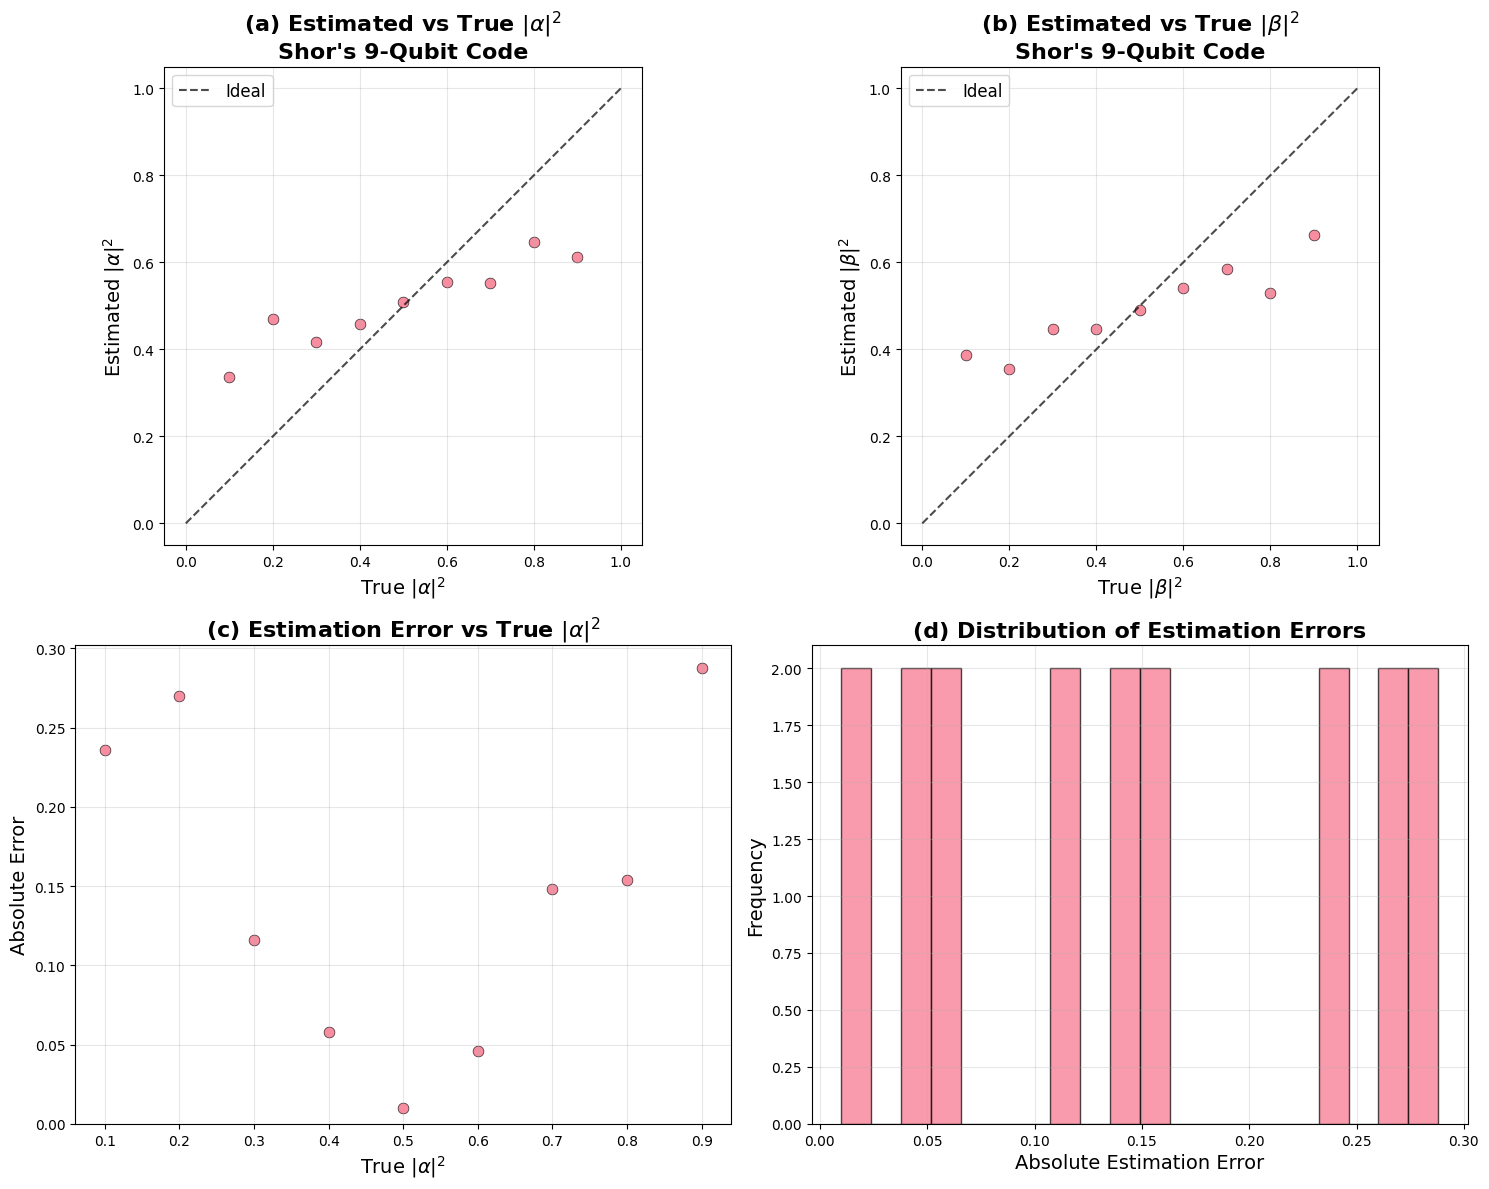


STATISTICAL SUMMARY
Mean absolute error for |α|²: 0.147333
Std deviation of errors: 0.094770
Maximum error: 0.288000
Minimum error: 0.010000

DETAILED RESULTS TABLE
True |α|²  Est. |α|²    Error      True |β|²  Est. |β|²    Error     
--------------------------------------------------------------------------------
0.100      0.336000     0.236000   0.900      0.664000     0.236000  
0.200      0.470000     0.270000   0.800      0.530000     0.270000  
0.300      0.416000     0.116000   0.700      0.584000     0.116000  
0.400      0.458000     0.058000   0.600      0.542000     0.058000  
0.500      0.510000     0.010000   0.500      0.490000     0.010000  
0.600      0.554000     0.046000   0.400      0.446000     0.046000  
0.700      0.552000     0.148000   0.300      0.448000     0.148000  
0.800      0.646000     0.154000   0.200      0.354000     0.154000  
0.900      0.612000     0.288000   0.100      0.388000     0.288000  


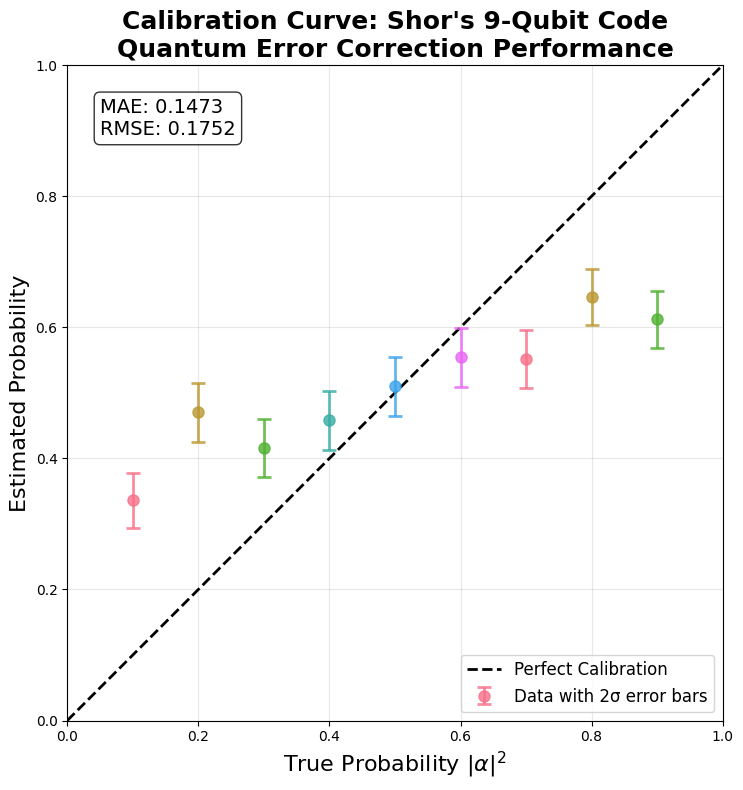

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import random
from tqdm import tqdm
import seaborn as sns

def run_shor_code_monte_carlo(alpha_squared_values, num_trials=1000, bit_flip_prob=0.5, phase_flip_prob=0.5):
    """
    Run Monte Carlo simulation of Shor's 9-qubit code for different initial states

    Parameters:
    - alpha_squared_values: List of |α|² values to test
    - num_trials: Number of Monte Carlo trials per alpha value
    - bit_flip_prob: Probability of bit-flip error
    - phase_flip_prob: Probability of phase-flip error

    Returns:
    - Dictionary with results for each alpha value
    """

    results = {}

    for alpha_squared in tqdm(alpha_squared_values, desc="Running Monte Carlo Simulation"):
        alpha = np.sqrt(alpha_squared)
        beta = np.sqrt(1 - alpha_squared)

        zero_counts = 0
        one_counts = 0
        syndrome_stats = {}

        for trial in range(num_trials):
            # Initialize registers
            data = QuantumRegister(9, 'data')
            bit_syndrome = QuantumRegister(6, 'bit_syndrome')
            phase_syndrome = QuantumRegister(2, 'phase_syndrome')
            bit_meas = ClassicalRegister(6, 'bit_meas')
            phase_meas = ClassicalRegister(2, 'phase_meas')
            output_meas = ClassicalRegister(1, 'output')
            qc = QuantumCircuit(data, bit_syndrome, phase_syndrome, bit_meas, phase_meas, output_meas)

            # Step 1: Initialize logical qubit
            qc.initialize([alpha, beta], data[0])

            # Step 2: Encode using Shor's 9-qubit code
            # Phase-flip encoding
            qc.cx(data[0], data[3])
            qc.cx(data[0], data[6])
            qc.h(data[0])
            qc.h(data[3])
            qc.h(data[6])
            # Bit-flip encoding
            qc.cx(data[0], data[1])
            qc.cx(data[0], data[2])
            qc.cx(data[3], data[4])
            qc.cx(data[3], data[5])
            qc.cx(data[6], data[7])
            qc.cx(data[6], data[8])

            qc.barrier()

            # Step 3: Simulate random errors on random qubits
            error_qubit = random.randint(0, 8)
            bit_flip = random.random() < bit_flip_prob
            phase_flip = random.random() < phase_flip_prob

            if bit_flip:
                qc.x(data[error_qubit])
            if phase_flip:
                qc.z(data[error_qubit])

            qc.barrier()

            # Step 4: Syndrome measurement for bit-flip errors
            # Block 1: data[0,1,2]
            qc.cx(data[0], bit_syndrome[0])
            qc.cx(data[2], bit_syndrome[0])
            qc.cx(data[1], bit_syndrome[1])
            qc.cx(data[2], bit_syndrome[1])
            # Block 2: data[3,4,5]
            qc.cx(data[3], bit_syndrome[2])
            qc.cx(data[5], bit_syndrome[2])
            qc.cx(data[4], bit_syndrome[3])
            qc.cx(data[5], bit_syndrome[3])
            # Block 3: data[6,7,8]
            qc.cx(data[6], bit_syndrome[4])
            qc.cx(data[8], bit_syndrome[4])
            qc.cx(data[7], bit_syndrome[5])
            qc.cx(data[8], bit_syndrome[5])

            # Measure bit-flip syndromes
            qc.measure(bit_syndrome[0], bit_meas[0])
            qc.measure(bit_syndrome[1], bit_meas[1])
            qc.measure(bit_syndrome[2], bit_meas[2])
            qc.measure(bit_syndrome[3], bit_meas[3])
            qc.measure(bit_syndrome[4], bit_meas[4])
            qc.measure(bit_syndrome[5], bit_meas[5])

            # Correct bit-flip errors
            # Block 1
            with qc.if_test((bit_meas, 0b000010)):  # 10 in first block
                qc.x(data[0])
            with qc.if_test((bit_meas, 0b000001)):  # 01 in first block
                qc.x(data[1])
            with qc.if_test((bit_meas, 0b000011)):  # 11 in first block
                qc.x(data[2])
            # Block 2
            with qc.if_test((bit_meas, 0b001000)):  # 10 in second block
                qc.x(data[3])
            with qc.if_test((bit_meas, 0b000100)):  # 01 in second block
                qc.x(data[4])
            with qc.if_test((bit_meas, 0b001100)):  # 11 in second block
                qc.x(data[5])
            # Block 3
            with qc.if_test((bit_meas, 0b100000)):  # 10 in third block
                qc.x(data[6])
            with qc.if_test((bit_meas, 0b010000)):  # 01 in third block
                qc.x(data[7])
            with qc.if_test((bit_meas, 0b110000)):  # 11 in third block
                qc.x(data[8])

            qc.barrier()

            # Step 5: Syndrome measurement for phase-flip errors
            qc.h(data[0])
            qc.h(data[1])
            qc.h(data[2])
            qc.h(data[3])
            qc.h(data[4])
            qc.h(data[5])
            qc.h(data[6])
            qc.h(data[7])
            qc.h(data[8])

            qc.cx(data[0], phase_syndrome[0])
            qc.cx(data[1], phase_syndrome[0])
            qc.cx(data[2], phase_syndrome[0])
            qc.cx(data[3], phase_syndrome[0])
            qc.cx(data[4], phase_syndrome[0])
            qc.cx(data[5], phase_syndrome[0])

            qc.cx(data[3], phase_syndrome[1])
            qc.cx(data[4], phase_syndrome[1])
            qc.cx(data[5], phase_syndrome[1])
            qc.cx(data[6], phase_syndrome[1])
            qc.cx(data[7], phase_syndrome[1])
            qc.cx(data[8], phase_syndrome[1])

            qc.h(data[0])
            qc.h(data[1])
            qc.h(data[2])
            qc.h(data[3])
            qc.h(data[4])
            qc.h(data[5])
            qc.h(data[6])
            qc.h(data[7])
            qc.h(data[8])

            # Measure phase syndromes
            qc.measure(phase_syndrome[0], phase_meas[0])
            qc.measure(phase_syndrome[1], phase_meas[1])

            # Correct phase-flip errors
            with qc.if_test((phase_meas, 0b10)):  # First block
                qc.z(data[0])
                qc.z(data[1])
                qc.z(data[2])
            with qc.if_test((phase_meas, 0b01)):  # Third block
                qc.z(data[6])
                qc.z(data[7])
                qc.z(data[8])
            with qc.if_test((phase_meas, 0b11)):  # Second block
                qc.z(data[3])
                qc.z(data[4])
                qc.z(data[5])

            qc.barrier()

            # Step 6: Decode
            # Reverse bit-flip encoding
            qc.cx(data[0], data[2])
            qc.cx(data[0], data[1])
            qc.cx(data[3], data[5])
            qc.cx(data[3], data[4])
            qc.cx(data[6], data[8])
            qc.cx(data[6], data[7])
            # Reverse phase-flip encoding
            qc.h(data[6])
            qc.h(data[3])
            qc.h(data[0])
            qc.cx(data[0], data[6])
            qc.cx(data[0], data[3])

            # Measure logical qubit
            qc.measure(data[0], output_meas[0])

            # Execute
            simulator = AerSimulator()
            compiled_circuit = transpile(qc, simulator)
            result = simulator.run(compiled_circuit, shots=1).result()
            counts = result.get_counts()

            # Count results
            for key in counts:
                if key.split()[0] == '0':
                    zero_counts += 1
                else:
                    one_counts += 1

        # Calculate probabilities
        total_shots = zero_counts + one_counts
        estimated_alpha_squared = zero_counts / total_shots
        estimated_beta_squared = one_counts / total_shots

        results[alpha_squared] = {
            'true_alpha_squared': alpha_squared,
            'true_beta_squared': 1 - alpha_squared,
            'estimated_alpha_squared': estimated_alpha_squared,
            'estimated_beta_squared': estimated_beta_squared,
            'zero_counts': zero_counts,
            'one_counts': one_counts,
            'total_trials': total_shots
        }

    return results

def plot_results_comprehensive(results):
    """Create comprehensive research paper-style plots"""

    # Set style for research paper
    plt.style.use('default')
    sns.set_palette("husl")

    # Extract data
    alpha_squared_values = sorted(results.keys())
    true_alpha = [results[a]['true_alpha_squared'] for a in alpha_squared_values]
    est_alpha = [results[a]['estimated_alpha_squared'] for a in alpha_squared_values]
    true_beta = [results[a]['true_beta_squared'] for a in alpha_squared_values]
    est_beta = [results[a]['estimated_beta_squared'] for a in alpha_squared_values]

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Estimated vs True |α|²
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Ideal')
    ax1.scatter(true_alpha, est_alpha, s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax1.set_xlabel('True $|\\alpha|^2$', fontsize=14)
    ax1.set_ylabel('Estimated $|\\alpha|^2$', fontsize=14)
    ax1.set_title('(a) Estimated vs True $|\\alpha|^2$\nShor\'s 9-Qubit Code', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)
    ax1.set_aspect('equal')

    # Plot 2: Estimated vs True |β|²
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Ideal')
    ax2.scatter(true_beta, est_beta, s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax2.set_xlabel('True $|\\beta|^2$', fontsize=14)
    ax2.set_ylabel('Estimated $|\\beta|^2$', fontsize=14)
    ax2.set_title('(b) Estimated vs True $|\\beta|^2$\nShor\'s 9-Qubit Code', fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)
    ax2.set_aspect('equal')

    # Plot 3: Estimation error for |α|²
    alpha_errors = [abs(est - true) for est, true in zip(est_alpha, true_alpha)]
    ax3.scatter(true_alpha, alpha_errors, s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax3.set_xlabel('True $|\\alpha|^2$', fontsize=14)
    ax3.set_ylabel('Absolute Error', fontsize=14)
    ax3.set_title('(c) Estimation Error vs True $|\\alpha|^2$', fontsize=16, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(bottom=0)

    # Plot 4: Histogram of estimation errors
    all_errors = alpha_errors + [abs(est - true) for est, true in zip(est_beta, true_beta)]
    ax4.hist(all_errors, bins=20, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Absolute Estimation Error', fontsize=14)
    ax4.set_ylabel('Frequency', fontsize=14)
    ax4.set_title('(d) Distribution of Estimation Errors', fontsize=16, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistical summary
    print("\n" + "="*60)
    print("STATISTICAL SUMMARY")
    print("="*60)
    print(f"Mean absolute error for |α|²: {np.mean(alpha_errors):.6f}")
    print(f"Std deviation of errors: {np.std(alpha_errors):.6f}")
    print(f"Maximum error: {np.max(alpha_errors):.6f}")
    print(f"Minimum error: {np.min(alpha_errors):.6f}")

    # Print table of results
    print("\n" + "="*80)
    print("DETAILED RESULTS TABLE")
    print("="*80)
    print(f"{'True |α|²':<10} {'Est. |α|²':<12} {'Error':<10} {'True |β|²':<10} {'Est. |β|²':<12} {'Error':<10}")
    print("-"*80)
    for alpha_sq in alpha_squared_values:
        res = results[alpha_sq]
        alpha_error = abs(res['estimated_alpha_squared'] - res['true_alpha_squared'])
        beta_error = abs(res['estimated_beta_squared'] - res['true_beta_squared'])
        print(f"{res['true_alpha_squared']:<10.3f} {res['estimated_alpha_squared']:<12.6f} {alpha_error:<10.6f} "
              f"{res['true_beta_squared']:<10.3f} {res['estimated_beta_squared']:<12.6f} {beta_error:<10.6f}")

def plot_calibration_curve(results):
    """Create calibration curve plot"""
    plt.figure(figsize=(10, 8))

    alpha_squared_values = sorted(results.keys())
    true_alpha = [results[a]['true_alpha_squared'] for a in alpha_squared_values]
    est_alpha = [results[a]['estimated_alpha_squared'] for a in alpha_squared_values]

    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

    # Scatter plot with error bars (assuming binomial distribution)
    for i, (true, est) in enumerate(zip(true_alpha, est_alpha)):
        n = results[alpha_squared_values[i]]['total_trials']
        # Binomial standard error
        std_error = np.sqrt(est * (1 - est) / n)
        plt.errorbar(true, est, yerr=2*std_error, fmt='o',
                    capsize=5, capthick=2, elinewidth=2,
                    markersize=8, alpha=0.8, label='Data with 2σ error bars' if i == 0 else "")

    plt.xlabel('True Probability $|\\alpha|^2$', fontsize=16)
    plt.ylabel('Estimated Probability', fontsize=16)
    plt.title('Calibration Curve: Shor\'s 9-Qubit Code\nQuantum Error Correction Performance',
              fontsize=18, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal')

    # Add performance metrics
    mae = np.mean([abs(est - true) for est, true in zip(est_alpha, true_alpha)])
    rmse = np.sqrt(np.mean([(est - true)**2 for est, true in zip(est_alpha, true_alpha)]))

    plt.text(0.05, 0.95, f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}',
             transform=plt.gca().transAxes, fontsize=14,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Run the Monte Carlo simulation
if __name__ == "__main__":
    # Define alpha squared values to test
    alpha_squared_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    print("Starting Monte Carlo Simulation of Shor's 9-Qubit Code")
    print("="*60)
    print(f"Testing {len(alpha_squared_values)} different initial states")
    print(f"Trials per state: 500")
    print(f"Error probabilities: bit-flip=0.5, phase-flip=0.5")
    print("="*60)

    # Run simulation (reduce num_trials for faster execution)
    results = run_shor_code_monte_carlo(alpha_squared_values, num_trials=500)

    # Create comprehensive plots
    plot_results_comprehensive(results)

    # Create calibration curve
    plot_calibration_curve(results)